In [1]:
import matplotlib.pyplot as plt

colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

# 예시:
# predicted와 example_output이 [1, 1, 30, 30] 크기의 텐서라고 가정
#show_grid_side_by_side(task_input, task_output, predicted)


In [1]:
from bw_net import BWNet
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

def criterion(y_pred, y):
    y = y.long().squeeze(1)
    ce = F.cross_entropy(y_pred, y, ignore_index=0)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 20,
    'task_numbers': 10,  # equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20,  # equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.01,
}

# CUDA 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

# 모델을 GPU로 이동
model = BWNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=kwargs['outer_lr'])

for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    task_loss = 0
    total_samples = 0
    
    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]  # 데이터를 GPU로 이동
        total_samples += input_tensor.shape[0]
        for task_number in range(input_tensor.shape[0]):
            task_input = input_tensor[task_number]
            task_output = output_tensor[task_number]
            ex_input = example_input[task_number]
            ex_output = example_output[task_number]
            model.train()
            optimizer.zero_grad()
            prediction = model(task_input, ex_input, ex_output)
            prediction_class = torch.argmax(prediction, dim=1, keepdim=True)  # [1, 11, 30, 30] -> [1, 1, 30, 30]
            loss = criterion(prediction, task_output)
            loss.backward()
            optimizer.step()
            task_loss += loss.item()
            
    task_loss /= total_samples

    model.eval()
    correct = 0
    total_samples = 0
    with torch.no_grad():
        for data in tqdm(eval_loader, desc='Validation'):
            input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]  # 데이터를 GPU로 이동
            total_samples += input_tensor.shape[0] * 900
            for task_number in range(input_tensor.shape[0]):
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                ex_input = example_input[task_number]
                ex_output = example_output[task_number]
                prediction = model(task_input, ex_input, ex_output)
                prediction_class = torch.argmax(prediction, dim=1, keepdim=True)  # [1, 11, 30, 30] -> [1, 1, 30, 30]
                correct += (prediction_class == task_output).sum().item()

        show_grid_side_by_side(task_input.cpu(), task_output.cpu(), prediction_class.cpu())  # CPU로 이동하여 시각화
                
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {task_loss}, Accuracy: {100 * correct / total_samples}%')


Epoch 1/20


Training:  31%|███       | 13/42 [00:04<00:09,  3.05it/s]


KeyboardInterrupt: 

In [1]:
from bw_net_maml import BWNet_MAML
import torch
from thop import profile
from thop import clever_format

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BWNet_MAML(embed_size=1).to(device)
# 입력 텐서 생성
x = torch.randn(1, 1, 30, 30).to(device)

# FLOPs 및 파라미터 수 계산
try:
    flops, params = profile(model, inputs=(x,))
    flops, params = clever_format([flops, params], "%.3f")
    print(f"FLOPs: {flops}")
    print(f"파라미터 수: {params}")
except Exception as e:
    print(f"Error during profiling: {e}")
    print(f"Input shape: {x.shape}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
FLOPs: 34.578M
파라미터 수: 31.190M


Using cuda device
Epoch 1/25


Validation: 100%|██████████| 21/21 [01:01<00:00,  2.95s/it]


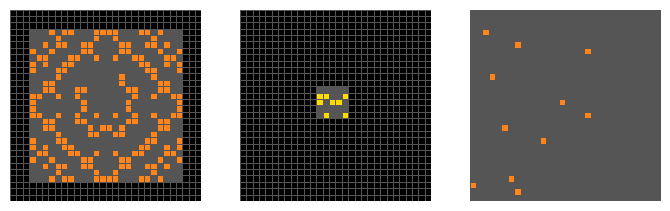

Epoch 1/25, Loss: 3.559558629989624, Accuracy: 125.24038461538461%
Epoch 2/25


Training:  57%|█████▋    | 12/21 [00:11<00:08,  1.08it/s]

In [1]:
from bw_net_maml import BWNet_MAML
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import gc
import random

mapping = {
            1: random.randint(1, 10),
            2: random.randint(11, 20),
            3: random.randint(21, 30),
            4: random.randint(31, 40),
            5: random.randint(41, 50),
            6: random.randint(51, 60),
            7: random.randint(61, 70),
            8: random.randint(71, 80),
            9: random.randint(81, 90),
            10: random.randint(91, 100)
        }

def remapping_output(tensor, mapping):
    # 원래 매핑을 기반으로 반대 매핑 생성
    reverse_mapping = {v: k for k, v in mapping.items()}

    temp_tensor = tensor.clone()
    for v in reverse_mapping:
        temp_tensor[temp_tensor == v] = -v  # 임시로 기존 값에 음수를 취해 중복을 피함

    # 최종 매핑 적용
    for v, k in reverse_mapping.items():
        temp_tensor[temp_tensor == -v] = k
    return temp_tensor



colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

def criterion(y_pred, y):
    y = y.long().squeeze(1)
    ce = F.cross_entropy(y_pred, y, ignore_index=0)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 25,
    'task_numbers': 20, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 10, #equal to inner model batch size
    'inner_lr': 0.001,
    'outer_lr': 0.001,
    'embed_size': 1,
    
}

# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device  
print(f'Using {device} device')


train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

outer_model = BWNet_MAML(embed_size=kwargs['embed_size']).to(device)
outer_optimizer= optim.AdamW(outer_model.parameters(),lr=kwargs['outer_lr'])

for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    task_loss = 0
    total_samples = 0
    outer_model.train()
    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]
        total_loss = 0
        inner_model = deepcopy(outer_model)
        inner_optimizer = optim.AdamW(inner_model.parameters(),lr=kwargs['inner_lr'])
        total_samples += input_tensor.shape[0]
        
        for task_number in range(input_tensor.shape[0]):
            ex_input = example_input[task_number]
            ex_output = example_output[task_number]
            prediction = inner_model(ex_input)

            ex_output = remapping_output(ex_output, mapping)
            prediction = remapping_output(prediction, mapping)

            loss = criterion(prediction, ex_output)

            inner_optimizer.zero_grad()
            loss.backward()
            inner_optimizer.step()
            
        for task_number in range(input_tensor.shape[0]):
            task_input = input_tensor[task_number]
            task_output = output_tensor[task_number]
            task_prediction = inner_model(task_input)

            task_output = remapping_output(task_output, mapping)
            task_prediction = remapping_output(task_prediction, mapping)

            task_loss = criterion(task_prediction, task_output)
            total_loss += task_loss
    
        outer_optimizer.zero_grad()
        total_loss.backward()
        outer_optimizer.step()
        del inner_model
        torch.cuda.empty_cache()
        gc.collect()
        

    del inner_optimizer
    torch.cuda.empty_cache()
    gc.collect()
    
    total_samples = 0
    total_loss = 0
    correct = 0
    outer_model.eval()
    for data in tqdm(eval_loader, desc='Validation'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]  # 데이터를 GPU로 이동
        total_samples += input_tensor.shape[0]
        for task_number in range(input_tensor.shape[0]):
            eval_model = deepcopy(outer_model)
            eval_optimizer = optim.AdamW(eval_model.parameters(),lr=kwargs['inner_lr'])
            eval_model.train()

            ex_input = example_input[task_number]
            ex_output = example_output[task_number]
            eval_prediction = eval_model(ex_input)

            ex_output = remapping_output(ex_output, mapping)
            eval_prediction = remapping_output(eval_prediction, mapping)

            loss = criterion(eval_prediction, ex_output)
            eval_optimizer.zero_grad()
            loss.backward()
            eval_optimizer.step()

            eval_model.eval()
            with torch.no_grad():
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                task_prediction = eval_model(task_input)

                task_output = remapping_output(task_output, mapping)
                task_prediction = remapping_output(task_prediction, mapping)

                task_loss = criterion(task_prediction, task_output)
                total_loss += task_loss
                
                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)  # [1, 11, 30, 30] -> [1, 1, 30, 30]
                correct += (prediction_class == task_output).sum().item()
            del eval_model
            del eval_optimizer
            torch.cuda.empty_cache()
            gc.collect()
            
    task_input = remapping_output(task_input, mapping)
    show_grid_side_by_side(task_input.cpu(), task_output.cpu(), prediction_class.cpu()) 
    torch.cuda.empty_cache()
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {task_loss}, Accuracy: {100 * correct / total_samples}%')

In [ ]:
from bw_net import BWNet
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

def criterion(y_pred,y):
    y = y.long()
    ce = F.cross_entropy(y_pred,y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"


kwargs = {
    'epochs': 5,
    'task_numbers': 10, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20, #equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
    
}
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

model = BWNet()
optimizer= optim.AdamW(model.parameters(),lr=kwargs['outer_lr'])

for data in train_loader:
      input_tensor, output_tensor, example_input, example_output = data
      print(f'Input: {input_tensor.shape}')
      for task_number in range(input_tensor.shape[0]):
        task_input = input_tensor[task_number]
        task_output = output_tensor[task_number]
        ex_input = example_input[task_number]
        ex_output = example_output[task_number]
        print(f'Task {task_number+1}/{kwargs["task_numbers"]}')
        print(f'Input: {task_input.shape}')
        print(f'Output: {task_output.shape}')
        print(f'Example Input: {ex_input.shape}')
        print(f'Example Output: {ex_output.shape}')
        print('---------------------------------')


Input: torch.Size([10, 1, 1, 30, 30])
Task 1/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 2/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 3/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 4/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 5/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 3

In [ ]:
from bw_net import BWNet
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

def criterion(y_pred,y):
    y = y.long()
    ce = F.cross_entropy(y_pred,y)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"


kwargs = {
    'epochs': 5,
    'task_numbers': 10, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20, #equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
    
}
train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

model = BWNet()
optimizer= optim.AdamW(model.parameters(),lr=kwargs['outer_lr'])

for data in eval_loader:
      input_tensor, output_tensor, example_input, example_output = data
      print(f'Input: {input_tensor.shape}')
      for task_number in range(input_tensor.shape[0]):
        task_input = input_tensor[task_number]
        task_output = output_tensor[task_number]
        ex_input = example_input[task_number]
        ex_output = example_output[task_number]
        print(f'Task {task_number+1}/{kwargs["task_numbers"]}')
        print(f'Input: {task_input.shape}')
        print(f'Output: {task_output.shape}')
        print(f'Example Input: {ex_input.shape}')
        print(f'Example Output: {ex_output.shape}')
        print('---------------------------------')


Input: torch.Size([10, 1, 1, 30, 30])
Task 1/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 2/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 3/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 4/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 30])
---------------------------------
Task 5/10
Input: torch.Size([1, 1, 30, 30])
Output: torch.Size([1, 1, 30, 30])
Example Input: torch.Size([10, 1, 30, 30])
Example Output: torch.Size([10, 1, 30, 3